In [0]:
!pip install mlflow==1.20.2

     |███████▉                        | 3.6 MB 6.0 MB/s eta 0:00:

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 738 kB 55.0 MB/s 
     |████████████████████████████████| 190 kB 61.3 MB/s 
     |████████████████████████████████| 150 kB 42.4 MB/s 
     |████████████████████████████████| 148 kB 56.6 MB/s 
     |████████████████████████████████| 78 kB 9.4 MB/s 
     |████████████████████████████████| 151 kB 64.0 MB/s 
     |████████████████████████████████| 57 kB 8.3 MB/s 
     |████████████████████████████████| 62 kB 2.3 MB/s 
     |████████████████████████████████| 610 kB 58.1 MB/s 
     |████████████████████████████████| 226 kB 58.1 MB/s 
     |████████████████████████████████| 97 kB 8.8 MB/s 
     |████████████████████████████████| 133 kB 58.3 MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158170 sha256=28390f91dd22b0d0ca5b3f6d82b58f8e10ed67b3803c730bc786d9854a64626d
  Stored in directory: /roo

In [0]:
!pip install spark

     |████████████████████████████████| 41 kB 107 kB/s 
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58763 sha256=fcb9d2dd73ce96224f9202215fe03ac12311688420b0c558c826abc0e6cae4ff
  Stored in directory: /root/.cache/pip/wheels/bc/0f/6c/b41528ca0fd4d46513185e90da91bc1c484bba6138641c5a62
Successfully built spark
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-3fe7ad9b-8516-4a4b-8249-93962bc8060f/bin/python -m pip install --upgrade pip' command.


In [0]:
import numpy as np
import pandas as pd
import matplotlib #
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn #
import spark
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve,confusion_matrix
from sklearn.model_selection import KFold
import mlflow

In [0]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("YourAppName").getOrCreate()

# File location and type
file_location = "/FileStore/tables/creditcard.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# Read the CSV file into a DataFrame
dataframe = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# Convert the Spark DataFrame to a Pandas DataFrame
df = dataframe.toPandas()


In [0]:
df = df.drop("Time", axis=1) # cette colonne n'apporte rien à notre analyse 
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Out[6]: <AxesSubplot:xlabel='Class', ylabel='count'>

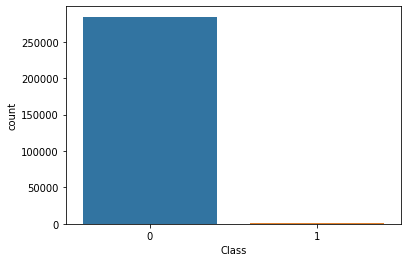

In [0]:
sns.countplot(x='Class',data=df)

In [0]:
normal = df[df.Class == 0].sample(frac=0.5,random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

In [0]:
print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 30)
Anomaly: (492, 30)


In [0]:
normal_train, normal_test = train_test_split(normal,test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)
normal_train, normal_validate = train_test_split(normal_train,test_size = 0.25, random_state = 2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2020)

In [0]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

In [0]:
y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

In [0]:
x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

In [0]:
print("Training sets:\nx_train: {} \ny_train:{}".format(x_train.shape, y_train.shape))
print("\nTesting sets:\nx_test: {} \ny_test:{}".format(x_test.shape, y_test.shape))
print("\nValidation sets:\nx_validate: {} \ny_validate: {}".format(x_validate.shape, y_validate.shape))

Training sets:
x_train: (85588, 29) 
y_train:(85588,)

Testing sets:
x_test: (28531, 29) 
y_test:(28531,)

Validation sets:
x_validate: (28531, 29) 
y_validate: (28531,)


In [0]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))

Out[14]: StandardScaler()

In [0]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

In [0]:
def train(sk_model, x_train, y_train):
    sk_model = sk_model.fit(x_train, y_train)
    train_acc = sk_model.score(x_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")

In [0]:
def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)
    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)
    mlflow.log_metric("eval_acc", eval_acc) # nous avons fait la même chose pour l'accuracy de test (evaluation)
    mlflow.log_metric("auc_score", auc_score)# aussi pour l'AUC score 
    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    roc_plot = plot_roc_curve(sk_model, x_test, y_test,name='Scikit-learn ROC Curve')
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    # nous avons dit à MLflow de sauvegarder ces deux figure afin de les consulter à chaque 
    # exécution d'une façon organisée comme nous allons le voir plus loin dans cet atelier  
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

In [0]:
#to configure your DataBricks CLI
token = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()
dbutils.fs.put("file:///root/.databrickscfg","[DEFAULT]\nhost=https://community.cloud.databricks.com\ntoken ="+token,overwrite=True)

Wrote 97 bytes.
Out[18]: True

/databricks/python/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Train Accuracy: 99.893%
Auc Score: 85.341%
Eval Accuracy: 99.874%


/databricks/python/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


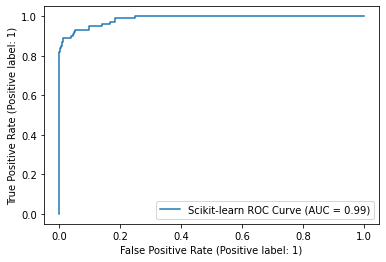

Model run:  e46f04e9aeaa473097d211b925f3a402


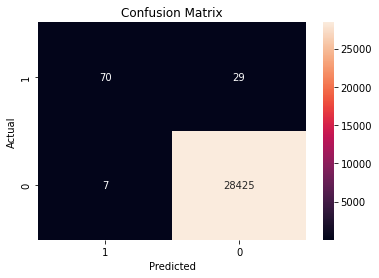

In [0]:
sk_model = LogisticRegression(random_state=None,max_iter=10, solver='newton-cg')
mlflow.set_experiment("/Users/alioune.ndao@um6p.ma/scikit_learn_experiment1")
with mlflow.start_run():
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [0]:

# define evaluation

# define search space
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

model = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)
mlflow.set_experiment("/Users/alioune.ndao@um6p.ma/scikit_learn_experiment1")
with mlflow.start_run():
    search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
    sk_model = search.fit(x_train, y_train)
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    print("Model run:" ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [0]:
all_runs = mlflow.search_runs(max_results=10)  # Note : This is pandas dataframe
display(all_runs)

run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.auc_score,metrics.eval_acc,metrics.train_acc,tags.mlflow.databricks.cluster.id,tags.mlflow.databricks.notebookRevisionID,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.databricks.notebookPath,tags.mlflow.runName,tags.mlflow.databricks.notebookID,tags.mlflow.source.type,tags.mlflow.databricks.cluster.info,tags.mlflow.databricks.notebook.commandID,tags.mlflow.databricks.webappURL,tags.mlflow.databricks.cluster.libraries,tags.mlflow.log-model.history
1a361170f66241cdbb17121a8747d6d4,3566423220450575,FAILED,dbfs:/databricks/mlflow-tracking/3566423220450575/1a361170f66241cdbb17121a8747d6d4/artifacts,2023-11-09T21:47:27.306+0000,2023-11-09T22:45:28.455+0000,null,null,null,1109-214035-i45r5gg9,1699569928997,alioune.ndao@um6p.ma,/Users/alioune.ndao@um6p.ma/Untitled Notebook 2023-11-08 08:50:15,/Users/alioune.ndao@um6p.ma/Untitled Notebook 2023-11-08 08:50:15,unequaled-bug-29,4077717370712957,NOTEBOOK,"{""cluster_name"":""My Cluster"",""spark_version"":""12.2.x-scala2.12"",""node_type_id"":""dev-tier-node"",""driver_node_type_id"":""dev-tier-node"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""num_workers"":0}",2137429343358729232_5524707683158618602_384ab376b2c64782a7502076948de35c,https://community.cloud.databricks.com,"{""installable"":[],""redacted"":[]}",null
e46f04e9aeaa473097d211b925f3a402,3566423220450575,FINISHED,dbfs:/databricks/mlflow-tracking/3566423220450575/e46f04e9aeaa473097d211b925f3a402/artifacts,2023-11-09T21:47:02.176+0000,2023-11-09T21:47:12.129+0000,0.8534122528037835,0.9987382145736217,0.9989250829555545,1109-214035-i45r5gg9,1699566432558,alioune.ndao@um6p.ma,/Users/alioune.ndao@um6p.ma/Untitled Notebook 2023-11-08 08:50:15,/Users/alioune.ndao@um6p.ma/Untitled Notebook 2023-11-08 08:50:15,enthused-slug-247,4077717370712957,NOTEBOOK,"{""cluster_name"":""My Cluster"",""spark_version"":""12.2.x-scala2.12"",""node_type_id"":""dev-tier-node"",""driver_node_type_id"":""dev-tier-node"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""num_workers"":0}",2137429343358729232_9074828659207230581_c2de31380971402d95a562062d5def41,https://community.cloud.databricks.com,"{""installable"":[],""redacted"":[]}","[{""artifact_path"":""log_reg_model"",""flavors"":{""python_function"":{""model_path"":""model.pkl"",""loader_module"":""mlflow.sklearn"",""python_version"":""3.9.5"",""env"":""conda.yaml""},""sklearn"":{""pickled_model"":""model.pkl"",""sklearn_version"":""1.0.2"",""serialization_format"":""cloudpickle""}},""run_id"":""e46f04e9aeaa473097d211b925f3a402"",""utc_time_created"":""2023-11-09 21:47:08.462221"",""databricks_runtime"":""12.2.x-scala2.12""}]"
bab39d2cade6486aba278d0de2638774,3566423220450575,FAILED,dbfs:/databricks/mlflow-tracking/3566423220450575/bab39d2cade6486aba278d0de2638774/artifacts,2023-11-09T00:18:19.271+0000,2023-11-09T00:41:04.679+0000,null,null,null,1109-000820-sa38ucg,1699490465110,alioune.ndao@um6p.ma,/Users/alioune.ndao@um6p.ma/Untitled Notebook 2023-11-08 08:50:15,/Users/alioune.ndao@um6p.ma/Untitled Notebook 2023-11-08 08:50:15,popular-dolphin-197,4077717370712957,NOTEBOOK,"{""cluster_name"":""My Cluster"",""spark_version"":""12.2.x-scala2.12"",""node_type_id"":""dev-tier-node"",""driver_node_type_id"":""dev-tier-node"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""num_workers"":0}",1242336018587653160_7646725868834750117_75660ce62aa343c9bf7fded89e785a0e,https://community.cloud.databricks.com,"{""installable"":[],""redacted"":[]}",null
61956a4122c949aaaef07c7a32a4d038,3566423220450575,FINISHED,dbfs:/databricks/mlflow-tracking/3566423220450575/61956a4122c949aaaef07c7a32a4d038/artifacts,2023-11-09T00:17:48.852+0000,2023-11-09T00:17:57.238+0000,0.8534122528037835,0.9987382145736217,0.9989250829555545,1109-000820-sa38ucg,1699489077694,alioune.ndao@um6p.ma,/Users/alioune.ndao@um6p.ma/Untitled Notebook 2023-11-08 08:50:15,/Users/alioune.ndao@um6p.ma/Untitled Notebook 2023-

/databricks/python/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train Accuracy: 86.442%
Auc Score: 43.418%
Eval Accuracy: 86.534%


/databricks/python/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


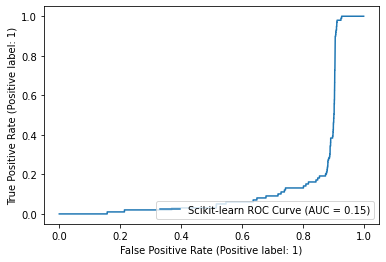

Model run:  6caed0fb9d7547cd93cff77d3955d737


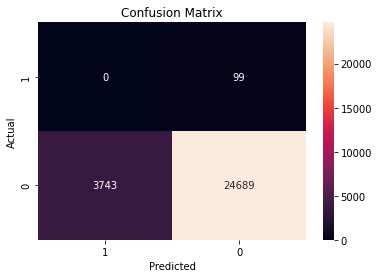

In [0]:
from sklearn.svm import SVC
sk_model = SVC(random_state=None, max_iter=10)
mlflow.set_experiment("/Users/alioune.ndao@um6p.ma/scikit_learn_experiment1")
with mlflow.start_run():
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()


In [0]:
### Le modèle regression logistique est meilleure que le modèle SVC